In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] ="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import numpy as np
import time
from PIL import Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import keras
from tensorflow.keras import layers, datasets
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
 

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

In [4]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        print(cm)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("显示百分比：")
#         np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    else:
        cm_ = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
#         print('显示具体数字：')
        print(cm_)
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # matplotlib版本问题，如果不加下面这行代码，则绘制的混淆矩阵上下只能显示一半，有的版本的matplotlib不需要下面的代码，分别试一下即可
    plt.ylim(len(classes) - 0.5, -0.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [5]:
def get_input_shape(type='Mobilenet'):
    if type == 'EfficientNet-B4':
#         input_shape=(224, 224, 3)
        input_shape=(380, 380, 3)
    elif type == 'VGG16':
        input_shape=(224, 224, 3)
    elif type == 'ResNet50':
        input_shape=(224, 224, 3)
    return input_shape

In [6]:
test_img_gen = ImageDataGenerator(fill_mode='nearest'
                                                 ,samplewise_center=True
                                                 ,samplewise_std_normalization=True
                                                ) 

def load_data(data_type, target_size, batch_size):
    # data path
    if data_type == 'esophagus_28':
        train_data_path = r'\\192.168.0.154\数据\口咽部\大部位27分类\res_train'
        val_data_path = r'\\192.168.0.154\数据\口咽部\大部位27分类\res_val'
#         test_data_path = r'\\192.168.0.154\数据\口咽部\大部位27分类\res_test'
        test_data_path = r'\\192.168.0.154\数据\口咽部\大部位27分类\res_test2'
    else:
        train_data_path = r'\\192.168.0.154\数据\口咽部\第8轮\res_train'
        val_data_path = r'\\192.168.0.154\数据\口咽部\第8轮\res_val'
        test_data_path = r'\\192.168.0.154\数据\口咽部\第8轮\res_test'
    #     test_data_path = '\\192.168.0.154\数据\口咽部\第8轮\valid_date_结果\富士'
    

    test_gen = test_img_gen.flow_from_directory(test_data_path,
                                    target_size = target_size,
                                    color_mode = 'rgb',
#                                     classes = [''],
                                    class_mode = 'categorical',
                                    batch_size = batch_size,
                                    shuffle = False,
                                    interpolation = 'nearest',
                                    keep_aspect_ratio=False
                                             )
    print('Test data loaded: total: %s, batch size: %s, num classes: %s\n' % (test_gen.n, test_gen.batch_size, test_gen.num_classes))
    
    return test_gen

## 打印图片名字

In [9]:
gen = load_data('esophagus_28', (224, 224), 32)
for i in gen:
    idx = (gen.batch_index - 1) * gen.batch_size
    print(gen.filenames[idx : idx + gen.batch_size])


Found 11550 images belonging to 28 classes.
Test data loaded: total: 11550, batch size: 32, num classes: 28

['01\\001_0_005_2020_06_12_08_55_8751-食管_0_active_standard_c99.jpg', '01\\001_0_005_2020_06_12_09_23_3761-食管_0_active_standard_c90.jpg', '01\\001_0_005_2020_06_12_09_46_2371-食管_0_active_standard_c99.jpg', '01\\001_0_005_2020_06_12_10_48_0251-食管_0_active_standard_c95.jpg', '01\\001_0_005_2020_06_12_11_07_7731-食管_0_active_standard_c98.jpg', '01\\001_0_005_2020_06_12_11_16_8611-食管_0_active_standard_c92.jpg', '01\\001_0_005_2020_06_12_12_07_9101-食管_0_active_standard_c99.jpg', '01\\001_0_01_2020_06_08_01_27_7111-食管_0_active_standard_c87.jpg', '01\\001_0_01_2020_06_08_08_19_0071-食管_0_active_standard_c98.jpg', '01\\001_0_01_2020_06_08_09_18_4641-食管_0_active_standard_c99.jpg', '01\\001_0_01_2020_06_08_09_28_6191-食管_0_active_standard_c55.jpg', '01\\001_0_01_2020_06_08_10_01_5141-食管_0_active_standard_c96.jpg', '01\\001_0_01_2020_06_08_10_34_9291-食管_0_active_standard_c99.jpg', '01\\001_0_0

['01\\001_0_01_2020_07_08_10_41_5792-贲门_0_active_not_standard_c90.jpg', '01\\001_0_01_2020_07_08_11_08_4081-食管_0_active_standard_c99.jpg', '01\\001_0_01_2020_07_08_11_42_1091-食管_0_active_standard_c99.jpg', '01\\001_0_01_2020_07_08_12_09_1781-食管_0_active_standard_c99.jpg', '01\\001_0_01_2020_07_08_12_22_4061-食管_0_active_standard_c98.jpg', '01\\001_0_01_2020_07_08_12_42_1881-食管_0_active_standard_c90.jpg', '01\\001_0_01_2020_07_09_08_14_7981-食管_0_active_standard_c74.jpg', '01\\001_0_01_2020_07_09_09_18_0501-食管_0_active_standard_c89.jpg', '01\\001_0_01_2020_07_09_11_48_5361-食管_0_active_standard_c92.jpg', '01\\001_0_01_2020_07_09_12_35_1321-食管_0_active_standard_c87.jpg', '01\\001_0_01_2020_07_10_09_02_7451-食管_0_active_standard_c96.jpg', '01\\001_0_01_2020_07_10_10_21_3361-食管_0_active_standard_c99.jpg', '01\\001_0_01_2020_07_10_10_55_5061-食管_0_active_standard_c97.jpg', '01\\001_0_01_2020_07_10_10_55_5062-贲门_0_active_standard_c99.jpg', '01\\001_0_01_2020_07_10_11_54_2651-食管_0_active_standard_

['01\\1-食管_0_c99&天津中医药2021_08_01_01_37_368.jpg', '01\\1-食管_0_c99&天津中医药2021_08_05_01_21_843.jpg', '01\\1-食管_0_c99&天津中医药2021_08_05_09_18_362.jpg', '01\\1-食管_0_c99&天津中医药2021_08_17_09_58_674.jpg', '01\\1-食管_0_c99&天津中医药2021_08_17_10_29_049.jpg', '01\\1-食管_0_c99&天津中医药2021_08_20_09_03_114.jpg', '01\\1-食管_0_c99&天津中医药2021_08_20_09_14_954.jpg', '01\\1-食管_0_c99&天津中医药2021_08_20_09_16_336.jpg', '01\\1-食管_0_c99&天津中医药2021_08_20_09_37_533.jpg', '01\\1-食管_0_c99&天津中医药2021_08_20_09_54_235.jpg', '01\\1-食管_0_c99&天津中医药2021_08_20_10_35_653.jpg', '01\\1-食管_0_c99&天津中医药2021_08_20_11_05_049.jpg', '01\\1-食管_0_c99&天津中医药2021_08_23_08_34_065.jpg', '01\\1-食管_0_c99&天津中医药2021_08_23_08_44_944.jpg', '01\\1-食管_0_c99&天津中医药2021_08_23_09_12_846.jpg', '01\\1-食管_0_c99&天津中医药2021_08_23_09_29_055.jpg', '01\\1-食管_0_c99&天津中医药2021_08_23_09_49_510.jpg', '01\\1-食管_0_c99&天津中医药2021_08_24_08_05_618.jpg', '01\\1-食管_0_c99&天津中医药2021_08_24_08_18_334.jpg', '01\\1-食管_0_c99&天津中医药2021_08_24_08_41_041.jpg', '01\\1-食管_0_c99&天津中医药2021_08_24_09_24_4

['02\\001_0_01_2020_07_07_12_21_4292-贲门_0_active_standard_c52.jpg', '02\\001_0_01_2020_07_08_09_02_5872-贲门_0_c99.jpg', '02\\001_0_01_2020_07_08_09_55_3202-贲门_0_c99.jpg', '02\\001_0_01_2020_07_08_11_08_4082-贲门_0_c99.jpg', '02\\001_0_01_2020_07_08_12_09_1782-贲门_0_active_standard_c99.jpg', '02\\001_0_01_2020_07_09_08_28_2142-贲门_0_active_standard_c99.jpg', '02\\001_0_01_2020_07_09_10_15_3992-贲门_0_c99.jpg', '02\\001_0_01_2020_07_09_11_37_2742-贲门_0_active_standard_c99.jpg', '02\\001_0_01_2020_07_09_11_48_5362-贲门_0_c99.jpg', '02\\001_0_01_2020_07_09_12_35_1322-贲门_0_c99.jpg', '02\\001_0_01_2020_07_10_09_02_7452-贲门_0_active_standard_c79.jpg', '02\\001_0_01_2020_07_10_10_21_3362-贲门_0_active_standard_c82.jpg', '02\\001_0_01_2020_07_10_11_49_6512-贲门_0_active_standard_c99.jpg', '02\\01.0000000001076.0009.1479183122.jpg', '02\\01.0000000001203.0059.1479262967.jpg', '02\\01.0000000001371.0001.1479355044.jpg', '02\\01.0000000047384.0005.1517015882.jpg', '02\\01.0000000047767.0011.1517444011.jpg', '02\

['02\\010001_0_005_2020_06_23_10_50_3292-贲门_0_active_not_standard_c50.jpg', '02\\010001_0_005_2020_06_23_10_50_3292-贲门_0_c99.jpg', '02\\010001_0_005_2020_06_24_08_15_9102-贲门_0_c99.jpg', '02\\010001_0_005_2020_06_28_09_04_6392-贲门_0_active_standard_c99.jpg', '02\\010001_0_005_2020_06_28_11_06_0752-贲门_0_active_standard_c99.jpg', '02\\010001_0_005_2020_06_28_11_48_5212-贲门_0_active_standard_c78.jpg', '02\\010001_0_005_2020_06_28_12_19_2432-贲门_0_active_standard_c73.jpg', '02\\010001_0_005_2020_06_29_09_11_3152-贲门_0_active_standard_c99.jpg', '02\\010001_0_005_2020_06_29_10_57_8672-贲门_0_active_standard_c99.jpg', '02\\010001_0_005_2020_06_29_11_49_1452-贲门_0_active_standard_c99.jpg', '02\\2-贲门_0_c89&包头附二院_2021_04_01_09_34_653.jpg', '02\\2-贲门_0_c89&包头附二院_2021_04_02_08_15_945.jpg', '02\\2-贲门_0_c89&包头附二院_2021_04_02_09_25_349.jpg', '02\\2-贲门_0_c89&包头附二院_2021_04_08_11_08_153.jpg', '02\\2-贲门_0_c89&温州中心_2021_09_16_10_56_074.jpg', '02\\2-贲门_0_c90&包头附二院_2021_04_27_03_29_019.jpg', '02\\2-贲门_0_c90&包头附二院_20

['02\\2-贲门_0_c99&天津中医药2021_09_18_08_17_798.jpg', '02\\2-贲门_0_c99&天津中医药2021_09_22_02_50_086.jpg', '02\\2-贲门_0_c99&天津中医药2021_09_22_08_15_498.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_01_02_58_141.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_01_03_36_761.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_01_10_39_645.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_03_02_03_341.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_03_09_50_656.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_03_10_23_203.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_03_10_37_857.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_03_11_52_057.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_04_09_45_688.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_04_10_22_926.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_04_10_34_495.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_04_10_47_565.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_06_02_31_851.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_06_02_51_020.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_06_03_56_669.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_07_02_21_992.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_07_03_03_550.jpg', '02\\2-贲门_0_c99&温州中心_2021_09_07_10_48_9

['03\\001_0_01_2020_06_29_09_09_9274-胃窦#后壁_0_active_standard_c72.jpg', '03\\001_0_01_2020_06_29_09_09_9276-胃窦#小弯_0_active_not_standard_c50.jpg', '03\\001_0_01_2020_06_29_09_09_9277-十二指肠球部_0_active_standard_c42.jpg', '03\\001_0_01_2020_06_29_11_13_8975-胃窦#前壁_0_active_standard_c65.jpg', '03\\001_0_01_2020_06_29_11_51_7373-胃窦#大弯_0_active_standard_c92.jpg', '03\\001_0_01_2020_06_29_12_38_7703-胃窦#大弯_0_active_standard_c81.jpg', '03\\001_0_01_2020_06_30_08_28_3873-胃窦#大弯_0_active_standard_c96.jpg', '03\\001_0_01_2020_06_30_10_18_6153-胃窦#大弯_0_active_standard_c78.jpg', '03\\001_0_01_2020_06_30_11_07_7233-胃窦#大弯_0_active_standard_c66.jpg', '03\\001_0_01_2020_06_30_11_07_7234-胃窦#后壁_0_active_standard_c51.jpg', '03\\001_0_01_2020_06_30_11_07_7235-胃窦#前壁_0_active_not_standard_c57.jpg', '03\\001_0_01_2020_06_30_11_52_3623-胃窦#大弯_0_active_standard_c92.jpg', '03\\001_0_01_2020_06_30_12_21_0373-胃窦#大弯_0_active_standard_c89.jpg', '03\\001_0_01_2020_06_30_12_32_4653-胃窦#大弯_0_active_standard_c75.jpg', '03\\001_0

['03\\010001_0_005_2020_06_23_09_13_4123-胃窦#大弯_0_active_standard_c70.jpg', '03\\010001_0_005_2020_06_23_10_27_5573-胃窦#大弯_0_active_standard_c92.jpg', '03\\010001_0_005_2020_06_23_10_27_5574-胃窦#后壁_0_active_standard_c66.jpg', '03\\010001_0_005_2020_06_24_08_15_9103-胃窦#大弯_0_active_standard_c99.jpg', '03\\010001_0_005_2020_06_28_09_04_6393-胃窦#大弯_0_active_standard_c95.jpg', '03\\010001_0_005_2020_06_28_09_24_1413-胃窦#大弯_0_active_standard_c99.jpg', '03\\010001_0_005_2020_06_28_11_48_5213-胃窦#大弯_0_active_standard_c93.jpg', '03\\010001_0_005_2020_06_29_10_57_8673-胃窦#大弯_0_active_standard_c98.jpg', '03\\3-胃窦#大弯_0_c81&包头附二院_2021_04_09_08_33_988.jpg', '03\\3-胃窦#大弯_0_c82&包头附二院_2021_04_13_03_09_832.jpg', '03\\3-胃窦#大弯_0_c82&包头附二院_2021_04_20_08_48_562.jpg', '03\\3-胃窦#大弯_0_c83&包头附二院_2021_04_12_09_58_767.jpg', '03\\3-胃窦#大弯_0_c83&包头附二院_2021_04_21_11_30_924.jpg', '03\\3-胃窦#大弯_0_c83&包头附二院_2021_04_26_09_43_601.jpg', '03\\3-胃窦#大弯_0_c84&包头附二院_2021_04_01_05_25_122.jpg', '03\\3-胃窦#大弯_0_c85&包头附二院_2021_04_09_08_28_8

['03\\3-胃窦#大弯_0_c99&温州中心_2021_09_09_11_21_409.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_10_02_27_088.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_10_02_40_538.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_10_03_17_210.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_10_09_57_383.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_10_10_14_211.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_12_08_29_960.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_12_10_23_295.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_13_02_52_396.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_13_03_09_373.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_13_08_23_616.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_13_12_19_957.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_14_08_40_745.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_14_09_27_440.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_14_09_57_700.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_14_10_04_474.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_14_10_25_851.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_14_10_38_334.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_09_15_08_41_538.jpg', '03\\3-胃窦#大弯_0_c99&温州中心_2021_0

['04\\010001_0_001_2020_07_27_01_44_2164-胃窦#后壁_0_c99.jpg', '04\\010001_0_001_2020_07_27_08_15_0344-胃窦#后壁_0_c97.jpg', '04\\010001_0_001_2020_07_27_08_15_0344-胃窦#后壁_0_c98.jpg', '04\\010001_0_001_2020_07_27_08_45_7824-胃窦#后壁_0_c99.jpg', '04\\010001_0_001_2020_07_27_08_53_7874-胃窦#后壁_0_c99.jpg', '04\\010001_0_001_2020_07_27_09_52_9754-胃窦#后壁_0_c99.jpg', '04\\010001_0_001_2020_07_27_10_17_6904-胃窦#后壁_0_c99.jpg', '04\\010001_0_001_2020_07_27_12_52_3384-胃窦#后壁_0_c99.jpg', '04\\010001_0_001_2020_07_28_08_36_6494-胃窦#后壁_0_c95.jpg', '04\\010001_0_001_2020_07_28_08_36_6494-胃窦#后壁_0_c98.jpg', '04\\010001_0_001_2020_07_28_08_36_6494-胃窦#后壁_0_c99.jpg', '04\\010001_0_001_2020_07_28_09_03_7554-胃窦#后壁_0_c99.jpg', '04\\010001_0_001_2020_07_28_09_59_3744-胃窦#后壁_0_active_standard_c97.jpg', '04\\010001_0_001_2020_07_28_09_59_3744-胃窦#后壁_0_c98.jpg', '04\\010001_0_001_2020_07_28_10_26_5093-胃窦#大弯_0_active_standard_c64.jpg', '04\\010001_0_001_2020_07_28_11_24_8674-胃窦#后壁_0_c99.jpg', '04\\010001_0_001_2020_07_28_11_39_0094

['04\\4-胃窦#后壁_0_c99&温州中心_2021_09_03_11_52_057.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_04_09_16_960.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_04_09_45_688.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_04_10_08_938.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_04_11_42_521.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_06_02_15_024.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_06_02_31_851.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_06_04_31_537.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_06_09_43_648.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_07_02_21_992.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_07_03_20_848.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_07_08_17_085.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_07_08_46_259.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_07_09_06_093.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_07_09_18_801.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_07_10_33_506.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_07_10_40_751.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_07_12_05_091.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_09_08_02_07_208.jpg', '04\\4-胃窦#后壁_0_c99&温州中心_2021_0

['05\\010001_0_001_2020_07_13_12_28_2555-胃窦#前壁_0_active_standard_c52.jpg', '05\\010001_0_001_2020_07_14_08_08_8515-胃窦#前壁_0_active_standard_c50.jpg', '05\\010001_0_001_2020_07_14_08_38_6545-胃窦#前壁_0_c90.jpg', '05\\010001_0_001_2020_07_14_12_12_8295-胃窦#前壁_0_active_standard_c59.jpg', '05\\010001_0_001_2020_07_14_12_22_9695-胃窦#前壁_0_active_standard_c85.jpg', '05\\010001_0_001_2020_07_15_12_35_7715-胃窦#前壁_0_active_standard_c99.jpg', '05\\010001_0_001_2020_07_16_08_12_1935-胃窦#前壁_0_active_standard_c86.jpg', '05\\010001_0_001_2020_07_16_09_09_9265-胃窦#前壁_0_active_not_standard_c56.jpg', '05\\010001_0_001_2020_07_16_09_09_9265-胃窦#前壁_0_c98.jpg', '05\\010001_0_001_2020_07_17_01_28_1305-胃窦#前壁_0_active_standard_c99.jpg', '05\\010001_0_001_2020_07_17_11_36_5445-胃窦#前壁_0_active_standard_c91.jpg', '05\\010001_0_001_2020_07_17_12_33_6613-胃窦#大弯_0_active_standard_c68.jpg', '05\\010001_0_001_2020_07_17_12_33_6615-胃窦#前壁_0_c99.jpg', '05\\010001_0_001_2020_07_20_01_19_6925-胃窦#前壁_0_active_standard_c96.jpg', '05\\01

['05\\010001_0_005_2020_06_29_09_11_3155-胃窦#前壁_0_active_standard_c99.jpg', '05\\5-胃窦#前壁_0_c71&包头附二院_2021_04_06_07_42_012.jpg', '05\\5-胃窦#前壁_0_c71&包头附二院_2021_04_12_04_02_067.jpg', '05\\5-胃窦#前壁_0_c71&包头附二院_2021_04_30_11_01_858.jpg', '05\\5-胃窦#前壁_0_c72&包头附二院_2021_04_16_10_58_357.jpg', '05\\5-胃窦#前壁_0_c72&北京朝阳_2021_09_15_11_22_869.jpg', '05\\5-胃窦#前壁_0_c73&包头附二院_2021_04_16_10_04_387.jpg', '05\\5-胃窦#前壁_0_c73&包头附二院_2021_04_19_04_16_139.jpg', '05\\5-胃窦#前壁_0_c74&天津中医药2021_09_14_09_01_152.jpg', '05\\5-胃窦#前壁_0_c76&包头附二院_2021_04_09_09_22_679.jpg', '05\\5-胃窦#前壁_0_c76&包头附二院_2021_04_22_10_23_024.jpg', '05\\5-胃窦#前壁_0_c78&包头附二院_2021_04_25_08_31_550.jpg', '05\\5-胃窦#前壁_0_c78&包头附二院_2021_04_29_07_01_485.jpg', '05\\5-胃窦#前壁_0_c79&包头附二院_2021_04_02_10_38_999.jpg', '05\\5-胃窦#前壁_0_c79&包头附二院_2021_04_16_12_00_974.jpg', '05\\5-胃窦#前壁_0_c81&包头附二院_2021_04_15_08_44_485.jpg', '05\\5-胃窦#前壁_0_c83&包头附二院_2021_04_01_05_02_334.jpg', '05\\5-胃窦#前壁_0_c83&包头附二院_2021_04_25_09_23_389.jpg', '05\\5-胃窦#前壁_0_c85&包头附二院_2021_04_01_10_00_2

['05\\5-胃窦#前壁_0_c99&温州中心_2021_09_07_09_39_863.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_08_02_07_208.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_08_02_25_513.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_08_03_15_667.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_08_09_34_443.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_08_10_11_085.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_08_10_17_702.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_08_10_59_834.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_08_11_36_902.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_09_03_12_845.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_09_04_34_605.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_09_09_13_024.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_09_11_21_409.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_10_02_27_088.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_10_02_40_538.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_10_02_52_900.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_10_03_17_210.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_10_03_42_422.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_09_10_07_49_463.jpg', '05\\5-胃窦#前壁_0_c99&温州中心_2021_0

['06\\001_0_01_2020_07_09_08_28_2146-胃窦#小弯_0_active_standard_c45.jpg', '06\\001_0_01_2020_07_09_10_15_3996-胃窦#小弯_0_active_standard_c99.jpg', '06\\001_0_01_2020_07_09_12_35_1323-胃窦#大弯_0_active_standard_c50.jpg', '06\\001_0_01_2020_07_09_12_35_1326-胃窦#小弯_0_active_standard_c99.jpg', '06\\001_0_01_2020_07_10_10_21_3366-胃窦#小弯_0_c96.jpg', '06\\001_0_01_2020_07_10_10_55_50615-正镜胃体中上部#前壁_0_active_not_standard_c51.jpg', '06\\001_0_01_2020_07_10_10_55_50615-正镜胃体中上部#前壁_0_c94.jpg', '06\\001_0_01_2020_07_10_11_49_6516-胃窦#小弯_0_active_standard_c97.jpg', '06\\001_0_01_2020_07_10_11_54_2656-胃窦#小弯_0_active_standard_c98.jpg', '06\\01.0000000046724.0005.1516925378.jpg', '06\\01.0000000047250.0039.1517186793_f2040.jpg', '06\\01.0000000047256.0052.1516928195_f5080.jpg', '06\\01.0000000047285.0055.1516926970.jpg', '06\\01.0000000047285.0096.1516927222_f4550.jpg', '06\\01.0000000047386.0055.1517017794_f1020.jpg', '06\\01.0000000098444_31_2019-03-05_08_46_06.jpg', '06\\01.0000000098633_21_2019-03-05_08_55_03.j

['06\\6-胃窦#小弯_0_c99&温州中心_2021_09_09_10_13_086.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_09_10_34_806.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_09_11_21_409.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_10_02_27_088.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_10_02_52_900.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_10_03_31_683.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_10_09_57_383.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_10_11_50_479.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_12_08_29_960.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_12_09_16_152.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_12_09_38_680.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_13_04_38_388.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_13_09_49_945.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_13_12_19_957.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_15_03_30_072.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_15_08_15_110.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_15_08_41_538.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_15_09_30_451.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_09_15_09_51_261.jpg', '06\\6-胃窦#小弯_0_c99&温州中心_2021_0

['07\\001_0_01_2020_07_10_11_49_6517-十二指肠球部_0_active_standard_c99.jpg', '07\\001_0_01_2020_07_10_11_54_2657-十二指肠球部_0_active_standard_c99.jpg', '07\\01.0000000000023.0004.1478483586.jpg', '07\\01.0000000000097.0012.1478498264.jpg', '07\\01.0000000000241.0006.1478568587.jpg', '07\\01.0000000000307.0006.1478653498.jpg', '07\\01.0000000000855.0023.1479095317.jpg', '07\\010001_0_001_2020_06_30_07_55_7887-十二指肠球部_0_active_standard_c99.jpg', '07\\010001_0_001_2020_06_30_08_27_2047-十二指肠球部_0_c98.jpg', '07\\010001_0_001_2020_06_30_09_44_5657-十二指肠球部_0_active_not_standard_c35.jpg', '07\\010001_0_001_2020_07_01_08_04_6657-十二指肠球部_0_active_not_standard_c50.jpg', '07\\010001_0_001_2020_07_01_12_50_5577-十二指肠球部_0_active_not_standard_c50.jpg', '07\\010001_0_001_2020_07_02_08_22_79412-正镜胃体下部#小弯_0_active_not_standard_c43.jpg', '07\\010001_0_001_2020_07_02_08_22_7947-十二指肠球部_0_active_standard_c99.jpg', '07\\010001_0_001_2020_07_02_11_02_3767-十二指肠球部_0_active_not_standard_c50.jpg', '07\\010001_0_001_2020_07_06_

['07\\010001_0_005_2020_06_23_10_50_3297-十二指肠球部_0_active_standard_c99.jpg', '07\\010001_0_005_2020_06_23_11_16_9957-十二指肠球部_0_active_standard_c99.jpg', '07\\010001_0_005_2020_06_24_01_03_4057-十二指肠球部_0_active_standard_c99.jpg', '07\\010001_0_005_2020_06_24_08_15_9107-十二指肠球部_0_active_standard_c98.jpg', '07\\010001_0_005_2020_06_24_09_27_3857-十二指肠球部_0_active_standard_c97.jpg', '07\\010001_0_005_2020_06_28_09_04_6397-十二指肠球部_0_active_standard_c99.jpg', '07\\010001_0_005_2020_06_28_09_24_1417-十二指肠球部_0_active_standard_c99.jpg', '07\\010001_0_005_2020_06_28_11_06_0757-十二指肠球部_0_active_standard_c99.jpg', '07\\010001_0_005_2020_06_28_11_48_5217-十二指肠球部_0_active_standard_c99.jpg', '07\\010001_0_005_2020_06_29_08_46_3167-十二指肠球部_0_active_standard_c99.jpg', '07\\010001_0_005_2020_06_29_09_11_3157-十二指肠球部_0_active_standard_c97.jpg', '07\\010001_0_005_2020_06_29_10_57_8677-十二指肠球部_0_active_standard_c99.jpg', '07\\010001_0_005_2020_06_29_11_49_1457-十二指肠球部_0_active_not_standard_c49.jpg', '07\\010001_0_005_20

['07\\7-十二指肠球部_0_c99&温州中心_2021_09_17_08_56_786.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_17_09_14_123.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_17_09_44_810.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_17_10_37_975.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_02_17_645.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_03_06_646.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_04_08_743.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_08_05_171.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_08_52_003.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_09_07_883.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_09_24_020.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_09_46_890.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_10_04_097.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_10_21_013.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_10_54_821.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_20_11_19_753.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_22_02_02_106.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_22_02_19_943.jpg', '07\\7-十二指肠球部_0_c99&温州中心_2021_09_22_02_44_440.jpg', '07\\7-十二指肠

['08\\001_0_01_2020_07_03_08_55_6858-十二指肠降部_0_active_standard_c99.jpg', '08\\001_0_01_2020_07_03_09_19_2598-十二指肠降部_0_active_standard_c99.jpg', '08\\001_0_01_2020_07_03_10_41_7588-十二指肠降部_0_active_standard_c98.jpg', '08\\001_0_01_2020_07_03_10_59_6308-十二指肠降部_0_active_standard_c98.jpg', '08\\001_0_01_2020_07_03_11_16_6178-十二指肠降部_0_active_standard_c99.jpg', '08\\001_0_01_2020_07_03_11_45_2088-十二指肠降部_0_active_standard_c99.jpg', '08\\001_0_01_2020_07_06_01_18_3608-十二指肠降部_0_active_standard_c99.jpg', '08\\001_0_01_2020_07_06_01_18_3608-十二指肠降部_0_c100.jpg', '08\\001_0_01_2020_07_06_02_06_7528-十二指肠降部_0_active_standard_c100.jpg', '08\\001_0_01_2020_07_06_02_27_2398-十二指肠降部_0_active_standard_c99.jpg', '08\\001_0_01_2020_07_06_09_03_7468-十二指肠降部_0_active_standard_c52.jpg', '08\\001_0_01_2020_07_06_09_17_1008-十二指肠降部_0_active_standard_c100.jpg', '08\\001_0_01_2020_07_06_12_07_4348-十二指肠降部_0_active_standard_c99.jpg', '08\\001_0_01_2020_07_07_01_45_2908-十二指肠降部_0_active_standard_c100.jpg', '08\\001_0_01_202

['08\\8-十二指肠降部_0_c94&北京朝阳_2021_09_07_10_49_155.jpg', '08\\8-十二指肠降部_0_c95&包头附二院_2021_04_07_07_59_746.jpg', '08\\8-十二指肠降部_0_c95&包头附二院_2021_04_09_07_49_184.jpg', '08\\8-十二指肠降部_0_c95&包头附二院_2021_04_19_11_19_822.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_08_20_09_16_336.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_08_20_10_35_653.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_08_20_11_05_049.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_08_24_08_41_041.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_08_25_10_02_941.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_09_01_08_18_958.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_09_06_09_50_234.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_09_08_08_17_034.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_09_08_10_27_161.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_09_10_10_25_720.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_09_13_09_18_185.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_09_13_10_26_449.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_09_14_08_15_801.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_09_14_08_41_470.jpg', '08\\8-十二指肠降部_0_c99&天津中医药2021_09_14_10_15_073.jpg', '08\\8-十

['08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_02_43_466.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_03_00_919.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_03_16_256.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_03_34_354.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_03_51_531.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_08_10_972.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_08_39_796.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_08_55_625.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_09_10_398.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_09_28_174.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_09_41_662.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_09_54_490.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_10_09_510.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_10_16_795.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_10_30_291.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_10_41_745.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_23_10_55_154.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_24_02_01_572.jpg', '08\\8-十二指肠降部_0_c99&温州中心_2021_09_24_02_18_398.jpg', '08\\8-十二指肠

['09\\001_0_01_2020_06_29_12_38_7709-正镜胃体下部#大弯_0_c99.jpg', '09\\001_0_01_2020_06_30_08_28_3879-正镜胃体下部#大弯_0_active_standard_c64.jpg', '09\\001_0_01_2020_06_30_08_51_6309-正镜胃体下部#大弯_0_active_standard_c85.jpg', '09\\001_0_01_2020_06_30_10_18_6159-正镜胃体下部#大弯_0_active_standard_c82.jpg', '09\\001_0_01_2020_06_30_10_27_43610-正镜胃体下部#后壁_0_active_not_standard_c33.jpg', '09\\001_0_01_2020_06_30_10_27_4369-正镜胃体下部#大弯_0_active_standard_c45.jpg', '09\\001_0_01_2020_06_30_11_07_7239-正镜胃体下部#大弯_0_active_standard_c73.jpg', '09\\001_0_01_2020_06_30_11_52_3629-正镜胃体下部#大弯_0_active_not_standard_c33.jpg', '09\\001_0_01_2020_06_30_11_52_3629-正镜胃体下部#大弯_0_c91.jpg', '09\\001_0_01_2020_06_30_12_09_65210-正镜胃体下部#后壁_0_active_not_standard_c33.jpg', '09\\001_0_01_2020_06_30_12_09_6529-正镜胃体下部#大弯_0_active_not_standard_c50.jpg', '09\\001_0_01_2020_06_30_12_21_0379-正镜胃体下部#大弯_0_active_standard_c65.jpg', '09\\001_0_01_2020_06_30_12_32_46510-正镜胃体下部#后壁_0_active_standard_c31.jpg', '09\\001_0_01_2020_06_30_12_32_46511-正镜胃体下部#前壁_0_a

['09\\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_06_11_27_984.jpg', '09\\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_09_07_51_391.jpg', '09\\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_10_10_02_509.jpg', '09\\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_11_10_12_679.jpg', '09\\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_11_11_12_130.jpg', '09\\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_17_09_32_097.jpg', '09\\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_18_02_07_561.jpg', '09\\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_23_11_20_767.jpg', '09\\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_09_07_10_49_155.jpg', '09\\9-正镜胃体下部#大弯_0_c98&天津中医药2021_08_25_08_25_742.jpg', '09\\9-正镜胃体下部#大弯_0_c98&天津中医药2021_08_25_08_46_602.jpg', '09\\9-正镜胃体下部#大弯_0_c98&温州中心_2021_09_01_11_09_161.jpg', '09\\9-正镜胃体下部#大弯_0_c98&温州中心_2021_09_04_10_47_565.jpg', '09\\9-正镜胃体下部#大弯_0_c98&温州中心_2021_09_06_04_31_537.jpg', '09\\9-正镜胃体下部#大弯_0_c98&温州中心_2021_09_07_10_13_891.jpg', '09\\9-正镜胃体下部#大弯_0_c98&温州中心_2021_09_09_03_27_193.jpg', '09\\9-正镜胃体下部#大弯_0_c98&温州中心_2021_09_09_08_18_814.jpg', '09\\9-正镜胃体下部#大弯_0_c98&温州中心_2021_09_13_09_49_945.jpg', '09\\9-正镜

['10\\001_0_01_2020_06_08_10_34_92910-正镜胃体下部#后壁_0_active_standard_c98.jpg', '10\\001_0_01_2020_06_08_11_10_78010-正镜胃体下部#后壁_0_active_standard_c84.jpg', '10\\001_0_01_2020_06_08_12_12_87014-正镜胃体中上部#后壁_0_c97.jpg', '10\\001_0_01_2020_06_09_08_19_87910-正镜胃体下部#后壁_0_active_standard_c91.jpg', '10\\001_0_01_2020_06_09_09_33_53114-正镜胃体中上部#后壁_0_active_standard_c57.jpg', '10\\001_0_01_2020_06_09_10_14_34010-正镜胃体下部#后壁_0_c98.jpg', '10\\001_0_01_2020_06_09_10_14_34015-正镜胃体中上部#前壁_0_active_not_standard_c50.jpg', '10\\001_0_01_2020_06_09_10_33_34110-正镜胃体下部#后壁_0_c99.jpg', '10\\001_0_01_2020_06_09_11_20_86310-正镜胃体下部#后壁_0_active_standard_c92.jpg', '10\\001_0_01_2020_06_09_11_43_44514-正镜胃体中上部#后壁_0_active_standard_c67.jpg', '10\\001_0_01_2020_06_10_01_10_59014-正镜胃体中上部#后壁_0_active_standard_c79.jpg', '10\\001_0_01_2020_06_10_07_59_49910-正镜胃体下部#后壁_0_active_standard_c57.jpg', '10\\001_0_01_2020_06_10_08_42_38610-正镜胃体下部#后壁_0_active_not_standard_c99.jpg', '10\\001_0_01_2020_06_10_08_42_38610-正镜胃体下部#后壁_0_c98.jpg', 

['10\\010001_0_001_2020_07_31_01_02_1169-正镜胃体下部#大弯_0_active_standard_c32.jpg', '10\\010001_0_005_2020_06_09_10_22_32214-正镜胃体中上部#后壁_0_active_not_standard_c72.jpg', '10\\010001_0_005_2020_06_10_12_24_55910-正镜胃体下部#后壁_0_active_not_standard_c99.jpg', '10\\010001_0_005_2020_06_10_12_24_55912-正镜胃体下部#小弯_0_active_not_standard_c39.jpg', '10\\010001_0_005_2020_06_11_09_22_80610-正镜胃体下部#后壁_0_active_standard_c99.jpg', '10\\010001_0_005_2020_06_16_08_24_23110-正镜胃体下部#后壁_0_c93.jpg', '10\\010001_0_005_2020_06_16_08_49_37010-正镜胃体下部#后壁_0_active_standard_c85.jpg', '10\\010001_0_005_2020_06_16_08_58_89510-正镜胃体下部#后壁_0_active_standard_c33.jpg', '10\\010001_0_005_2020_06_16_10_30_12010-正镜胃体下部#后壁_0_active_standard_c78.jpg', '10\\010001_0_005_2020_06_17_01_03_69910-正镜胃体下部#后壁_0_active_standard_c53.jpg', '10\\010001_0_005_2020_06_17_08_00_36510-正镜胃体下部#后壁_0_c99.jpg', '10\\010001_0_005_2020_06_17_11_34_30710-正镜胃体下部#后壁_0_active_standard_c52.jpg', '10\\010001_0_005_2020_06_18_11_46_25710-正镜胃体下部#后壁_0_c99.jpg', '10\\010

['11\\001_0_01_2020_06_24_11_34_95411-正镜胃体下部#前壁_0_active_standard_c99.jpg', '11\\001_0_01_2020_06_28_08_42_24611-正镜胃体下部#前壁_0_active_standard_c99.jpg', '11\\001_0_01_2020_06_28_08_56_15011-正镜胃体下部#前壁_0_c99.jpg', '11\\001_0_01_2020_06_28_11_07_89411-正镜胃体下部#前壁_0_active_standard_c75.jpg', '11\\001_0_01_2020_06_28_11_19_60611-正镜胃体下部#前壁_0_active_standard_c89.jpg', '11\\001_0_01_2020_06_28_12_19_46511-正镜胃体下部#前壁_0_c99.jpg', '11\\001_0_01_2020_06_29_09_09_92711-正镜胃体下部#前壁_0_active_not_standard_c85.jpg', '11\\001_0_01_2020_06_29_09_09_92711-正镜胃体下部#前壁_0_c99.jpg', '11\\001_0_01_2020_06_29_09_09_92712-正镜胃体下部#小弯_0_active_not_standard_c67.jpg', '11\\001_0_01_2020_06_29_10_53_12311-正镜胃体下部#前壁_0_c99.jpg', '11\\001_0_01_2020_06_29_11_13_89711-正镜胃体下部#前壁_0_active_standard_c99.jpg', '11\\001_0_01_2020_06_30_08_51_63011-正镜胃体下部#前壁_0_c99.jpg', '11\\001_0_01_2020_06_30_10_18_61511-正镜胃体下部#前壁_0_c99.jpg', '11\\001_0_01_2020_06_30_11_07_72311-正镜胃体下部#前壁_0_active_standard_c81.jpg', '11\\001_0_01_2020_07_01_08_28_49611-

['11\\010001_0_005_2020_06_22_11_29_66811-正镜胃体下部#前壁_0_active_standard_c94.jpg', '11\\010001_0_005_2020_06_23_09_13_41211-正镜胃体下部#前壁_0_active_standard_c95.jpg', '11\\010001_0_005_2020_06_23_09_41_38511-正镜胃体下部#前壁_0_active_standard_c99.jpg', '11\\010001_0_005_2020_06_24_08_15_91011-正镜胃体下部#前壁_0_active_standard_c99.jpg', '11\\010001_0_005_2020_06_24_09_02_47211-正镜胃体下部#前壁_0_active_not_standard_c48.jpg', '11\\010001_0_005_2020_06_24_09_02_47211-正镜胃体下部#前壁_0_c99.jpg', '11\\010001_0_005_2020_06_24_09_27_38511-正镜胃体下部#前壁_0_c99.jpg', '11\\010001_0_005_2020_06_28_09_04_63911-正镜胃体下部#前壁_0_active_standard_c39.jpg', '11\\010001_0_005_2020_06_28_11_06_07511-正镜胃体下部#前壁_0_active_standard_c99.jpg', '11\\010001_0_005_2020_06_28_12_19_24311-正镜胃体下部#前壁_0_active_standard_c99.jpg', '11\\010001_0_005_2020_06_29_08_46_31611-正镜胃体下部#前壁_0_active_not_standard_c98.jpg', '11\\010001_0_005_2020_06_29_08_46_31611-正镜胃体下部#前壁_0_c99.jpg', '11\\010001_0_005_2020_06_29_09_11_31511-正镜胃体下部#前壁_0_active_standard_c99.jpg', '11\\010001_

['11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_16_09_41_242.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_16_09_58_320.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_16_10_16_363.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_16_10_36_793.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_16_10_56_074.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_17_02_40_593.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_17_02_59_902.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_17_03_14_583.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_17_03_52_189.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_17_04_09_772.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_17_08_56_786.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_17_09_30_456.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_17_09_59_102.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_17_10_24_002.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_17_10_37_975.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_20_03_06_646.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_20_03_18_342.jpg', '11\\11-正镜胃体下部#前壁_0_c99&温州中心_2021_09_20_03_43_7

['12\\010001_0_001_2020_07_28_11_39_00912-正镜胃体下部#小弯_0_c99.jpg', '12\\010001_0_001_2020_07_29_10_46_83212-正镜胃体下部#小弯_0_active_standard_c87.jpg', '12\\010001_0_001_2020_07_30_09_12_74512-正镜胃体下部#小弯_0_c98.jpg', '12\\010001_0_001_2020_07_31_01_13_10212-正镜胃体下部#小弯_0_active_standard_c99.jpg', '12\\010001_0_005_2020_06_08_11_12_83712-正镜胃体下部#小弯_0_active_standard_c99.jpg', '12\\010001_0_005_2020_06_08_12_38_93712-正镜胃体下部#小弯_0_c98.jpg', '12\\010001_0_005_2020_06_09_08_46_07612-正镜胃体下部#小弯_0_active_not_standard_c98.jpg', '12\\010001_0_005_2020_06_09_09_11_47812-正镜胃体下部#小弯_0_active_standard_c99.jpg', '12\\010001_0_005_2020_06_09_10_47_14012-正镜胃体下部#小弯_0_active_standard_c99.jpg', '12\\010001_0_005_2020_06_10_10_06_73412-正镜胃体下部#小弯_0_active_standard_c97.jpg', '12\\010001_0_005_2020_06_10_10_16_18812-正镜胃体下部#小弯_0_active_standard_c47.jpg', '12\\010001_0_005_2020_06_10_12_56_28412-正镜胃体下部#小弯_0_active_standard_c98.jpg', '12\\010001_0_005_2020_06_11_09_30_72112-正镜胃体下部#小弯_0_active_standard_c99.jpg', '12\\010001_0_00

KeyboardInterrupt: 

## 打印图片路径

In [16]:
datagen = load_data('esophagus_28', (224, 224), 32)
ct, total_ct = 0, datagen.n // datagen.batch_size
img_paths = []
for i in gen:
    idx = (gen.batch_index - 1) * gen.batch_size
    print(gen.filepaths[idx : idx + gen.batch_size])

Found 11550 images belonging to 28 classes.
Test data loaded: total: 11550, batch size: 32, num classes: 28

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_06_18_11_27_4571-食管_0_active_standard_c96.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_06_18_11_48_5051-食管_0_active_standard_c97.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_06_18_12_11_8461-食管_0_active_standard_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_06_19_08_12_3121-食管_0_active_standard_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_06_19_08_18_8611-食管_0_active_standard_c96.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_06_19_08_47_5001-食管_0_active_standard_c93.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_06_19_08_47_5002-贲门_0_active_not_standard_c63.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_06_19_09_10_18

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_07_08_10_41_5792-贲门_0_active_not_standard_c90.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_07_08_11_08_4081-食管_0_active_standard_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_07_08_11_42_1091-食管_0_active_standard_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_07_08_12_09_1781-食管_0_active_standard_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_07_08_12_22_4061-食管_0_active_standard_c98.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_07_08_12_42_1881-食管_0_active_standard_c90.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_07_09_08_14_7981-食管_0_active_standard_c74.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_07_09_09_18_0501-食管_0_active_standard_c89.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\001_0_01_2020_07_09_11

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c98&北京朝阳_2021_08_23_08_48_684.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c98&北京朝阳_2021_09_08_09_50_522.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c98&北京朝阳_2021_09_09_09_25_881.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&北京朝阳_2021_08_02_02_06_084.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&北京朝阳_2021_08_02_07_52_698.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&北京朝阳_2021_08_02_08_28_035.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&北京朝阳_2021_08_02_08_44_457.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&北京朝阳_2021_08_02_09_10_762.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&北京朝阳_2021_08_02_09_56_498.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&北京朝阳_2021_08_02_10_21_222.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\r

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&天津中医药2021_09_09_10_56_607.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&天津中医药2021_09_10_08_19_384.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&天津中医药2021_09_10_08_30_062.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&天津中医药2021_09_10_08_53_276.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&天津中医药2021_09_10_09_31_338.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&天津中医药2021_09_10_10_06_401.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&天津中医药2021_09_13_08_45_926.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&天津中医药2021_09_13_09_02_866.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&天津中医药2021_09_13_09_18_185.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\01\\1-食管_0_c99&天津中医药2021_09_13_10_00_350.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\r

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\001_0_01_2020_07_07_12_21_4292-贲门_0_active_standard_c52.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\001_0_01_2020_07_08_09_02_5872-贲门_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\001_0_01_2020_07_08_09_55_3202-贲门_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\001_0_01_2020_07_08_11_08_4082-贲门_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\001_0_01_2020_07_08_12_09_1782-贲门_0_active_standard_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\001_0_01_2020_07_09_08_28_2142-贲门_0_active_standard_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\001_0_01_2020_07_09_10_15_3992-贲门_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\001_0_01_2020_07_09_11_37_2742-贲门_0_active_standard_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\001_0_01_2020_07_09_11_48_5362-贲门_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_te

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\010001_0_001_2020_07_30_08_46_9872-贲门_0_c100.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\010001_0_001_2020_07_30_08_46_9872-贲门_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\010001_0_001_2020_07_30_08_59_6652-贲门_0_active_standard_c91.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\010001_0_001_2020_07_30_08_59_6652-贲门_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\010001_0_001_2020_07_30_09_58_6472-贲门_0_active_standard_c96.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\010001_0_001_2020_07_30_09_58_6472-贲门_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\010001_0_001_2020_07_30_10_34_6512-贲门_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\010001_0_001_2020_07_31_01_02_1162-贲门_0_active_not_standard_c91.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\010001_0_001_2020_07_31_01_02_1162-贲门_0_c99.jpg', '\\\\192.168.0.154\

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&包头附二院_2021_04_07_03_37_320.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&包头附二院_2021_04_07_09_07_328.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&包头附二院_2021_04_07_11_18_660.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&包头附二院_2021_04_08_02_43_803.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&包头附二院_2021_04_09_10_42_537.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&包头附二院_2021_04_12_09_07_845.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&包头附二院_2021_04_12_11_10_063.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&包头附二院_2021_04_13_08_37_711.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&包头附二院_2021_04_13_09_23_833.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&包头附二院_2021_04_13_09_38_445.jpg', '\\\\192.168.0.154\\数据\\口咽部\\

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&天津中医药2021_09_18_08_17_798.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&天津中医药2021_09_22_02_50_086.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&天津中医药2021_09_22_08_15_498.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&温州中心_2021_09_01_02_58_141.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&温州中心_2021_09_01_03_36_761.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&温州中心_2021_09_01_10_39_645.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&温州中心_2021_09_03_02_03_341.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&温州中心_2021_09_03_09_50_656.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&温州中心_2021_09_03_10_23_203.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\02\\2-贲门_0_c99&温州中心_2021_09_03_10_37_857.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\r

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\001_0_01_2020_06_29_09_09_9274-胃窦#后壁_0_active_standard_c72.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\001_0_01_2020_06_29_09_09_9276-胃窦#小弯_0_active_not_standard_c50.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\001_0_01_2020_06_29_09_09_9277-十二指肠球部_0_active_standard_c42.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\001_0_01_2020_06_29_11_13_8975-胃窦#前壁_0_active_standard_c65.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\001_0_01_2020_06_29_11_51_7373-胃窦#大弯_0_active_standard_c92.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\001_0_01_2020_06_29_12_38_7703-胃窦#大弯_0_active_standard_c81.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\001_0_01_2020_06_30_08_28_3873-胃窦#大弯_0_active_standard_c96.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\001_0_01_2020_06_30_10_18_6153-胃窦#大弯_0_active_standard_c78.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\0

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\010001_0_001_2020_07_08_12_45_0873-胃窦#大弯_0_active_standard_c98.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\010001_0_001_2020_07_09_12_27_7433-胃窦#大弯_0_active_standard_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\010001_0_001_2020_07_09_12_27_7435-胃窦#前壁_0_active_standard_c57.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\010001_0_001_2020_07_10_08_19_5173-胃窦#大弯_0_active_standard_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\010001_0_001_2020_07_10_11_57_1253-胃窦#大弯_0_active_standard_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\010001_0_001_2020_07_16_09_29_1103-胃窦#大弯_0_active_standard_c57.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\010001_0_001_2020_07_20_01_19_6923-胃窦#大弯_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\010001_0_001_2020_07_21_01_25_2063-胃窦#大弯_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\01

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c98&包头附二院_2021_04_23_08_30_697.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c98&包头附二院_2021_04_25_04_17_309.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c98&包头附二院_2021_04_27_11_43_051.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c98&包头附二院_2021_04_30_03_09_202.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c98&北京朝阳_2021_08_09_09_54_798.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c98&北京朝阳_2021_08_17_08_46_142.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c98&北京朝阳_2021_09_07_10_49_155.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c98&天津中医药2021_08_23_09_12_846.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c98&温州中心_2021_09_02_11_54_376.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c98&温州中心_2021_09_04_09_45_688.jpg', '\\\\

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c99&温州中心_2021_09_09_11_21_409.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c99&温州中心_2021_09_10_02_27_088.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c99&温州中心_2021_09_10_02_40_538.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c99&温州中心_2021_09_10_03_17_210.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c99&温州中心_2021_09_10_09_57_383.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c99&温州中心_2021_09_10_10_14_211.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c99&温州中心_2021_09_12_08_29_960.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c99&温州中心_2021_09_12_10_23_295.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c99&温州中心_2021_09_13_02_52_396.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\03\\3-胃窦#大弯_0_c99&温州中心_2021_09_13_03_09_373.jpg', '\\\\192.

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\010001_0_001_2020_07_27_01_44_2164-胃窦#后壁_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\010001_0_001_2020_07_27_08_15_0344-胃窦#后壁_0_c97.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\010001_0_001_2020_07_27_08_15_0344-胃窦#后壁_0_c98.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\010001_0_001_2020_07_27_08_45_7824-胃窦#后壁_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\010001_0_001_2020_07_27_08_53_7874-胃窦#后壁_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\010001_0_001_2020_07_27_09_52_9754-胃窦#后壁_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\010001_0_001_2020_07_27_10_17_6904-胃窦#后壁_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\010001_0_001_2020_07_27_12_52_3384-胃窦#后壁_0_c99.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\010001_0_001_2020_07_28_08_36_6494-胃窦#后壁_0_c95.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_tes

['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\4-胃窦#后壁_0_c98&温州中心_2021_09_03_02_03_341.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\4-胃窦#后壁_0_c98&温州中心_2021_09_03_09_20_528.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\4-胃窦#后壁_0_c98&温州中心_2021_09_08_02_37_520.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\4-胃窦#后壁_0_c98&温州中心_2021_09_13_11_14_000.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\4-胃窦#后壁_0_c98&温州中心_2021_09_20_10_35_435.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\4-胃窦#后壁_0_c98&温州中心_2021_09_24_02_34_872.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\4-胃窦#后壁_0_c99&包头附二院_2021_04_01_08_56_212.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\4-胃窦#后壁_0_c99&包头附二院_2021_04_02_08_15_945.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\4-胃窦#后壁_0_c99&包头附二院_2021_04_09_07_32_222.jpg', '\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2\\04\\4-胃窦#后壁_0_c99&包头附二院_2021_04_13_03_09_832.jpg', '\\\\

KeyboardInterrupt: 

In [10]:
import shutil
modl_types = ['VGG16', 'ResNet50', 'EfficientNet-B4']
img_shapes = [(224, 224), (224, 224), (380, 380)]
# img_shapes = [(224, 224), (224, 224), (224, 224)]
data_types = ['esophagus_28', 'pharynx_5']
batch_sizes = 32, 64
def predict(mdl_idx, data_idx, mdl_path):
    modl_type = modl_types[mdl_idx]
    img_shape = img_shapes[mdl_idx]
    data_type = data_types[data_idx]
    BATCH_SIZE = batch_sizes[data_idx]
    
    # 定义模型
#     model = tf.keras.models.load_model(r'D:\projects\Vision\TrainedModels\pharynx_5_VGG16_2022052709_01-0.978.hdf5')
    model = tf.keras.models.load_model(mdl_path)
    

    # 加载数据
    test_gen = load_data(data_type, img_shape, BATCH_SIZE)

    # 训练
    pred, lbl, img_path = [], [], []
    ct, total_ct = 0, test_gen.n // BATCH_SIZE
    for img, l in test_gen:
        pred.extend(np.argmax(model.predict(img), axis=1))
        lbl.extend(np.argmax(l, axis=1))
        idx = (test_gen.batch_index - 1) * test_gen.batch_size
        img_path.extend(test_gen.filepaths[idx : idx + test_gen.batch_size])
        ct = ct + 1
        if ct == total_ct :
            break
            
    # 保存badcase图片
#     for a,b,c in zip(pred, lbl, img_path):
#         if a != b:
#             print(a, b, c)
#             shutil.copy(c, c.replace('res_test2', 'res_test2_bad'))
            
    s = confusion_matrix(lbl, pred)
    return s


In [8]:
def calc_acc_from_matrix(matrix):
    line_correct = [line[i] for i, line in enumerate(matrix)]
    line_sum = [sum(line) for line in matrix]
    
    correct_ratio = [line_correct[k] / line_sum[k] for k in range(len(line_correct))]
    total_correct = sum(line_correct) / sum(line_sum)
    
    for i, c in enumerate(correct_ratio):
        print("%s:%.2f" % (i, c*100) + '%')
    print("overall acc: %.2f" % (total_correct*100) + '%')

## EfficientNet

In [18]:
s_eff = predict(0, 0, r'D:\projects\Vision\ckpts\esophagus_28_EfficientNet-B4_20220610_03-0.967.hdf5')
plot_confusion_matrix(s_eff, ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27"], False, 'Confusion matrix')
calc_acc_from_matrix(s_eff)

Found 11820 images belonging to 28 classes.
Test data loaded: total: 11820, batch size: 32, num classes: 28

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step
[[119   7  35   4   3   1   4  12   4   8   0   0   0   1   0   0   3   1
    0   0   0   0   0   0   1   0   0  67]
 [  0 509  27   0   1   0   0   4   2   2   0   0   0   0   1   0   0   0
    0   0   0   0   0   0   0   0   0   4]
 [  0  20 472   0   2   0   0   2   1   0   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0 462  16  14   2   0   1   3   1   0   0   0   0   0   0   1
    0   0   0   0   0   0   0   0   0   0]
 [  1   0   0  37 365   1   2   0   0   0   0   0   0   0   1   0   0   0
    0   0   0   0   0   0   1   0   0   0]
 [  0   0   0  35   0 450  11   2   0   0   0   2   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   8  16  17 312   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  7   0   0   0   1   1   1 466  13   6   0   2   0   0   0   0   0   0
    0   0   0   0   0   0   1   1   0   1]
 [  0   0   

## EfficientNet2  380尺寸，全开放finetune

Found 11820 images belonging to 28 classes.
Test data loaded: total: 11820, batch size: 32, num classes: 28

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 48ms/step
4 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_005_2020_06_12_11_07_7734-胃窦#后壁_0_active_not_standard_c66.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_08_12_21_8392-贲门_0_active_standard_c99.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_08_12_41_3892-贲门_0_active_standard_c57.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_09_09_33_5312-贲门_0_active_standard_c77.jpg
7 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_09_10_14_3402-贲门_0_active_standard_c68.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_09_11_03_0682-贲门_0_c99.jpg
1 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_09_11_20_8632-贲门_0_active_standard_c71.jpg
7 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_10_07_59_4997-十二指肠球部_0_active_standard_c99.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_11_10_56_1272-贲门_0_acti

9 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\010001_0_001_2020_07_09_09_58_4303-胃窦#大弯_0_active_standard_c93.jpg
9 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\010001_0_001_2020_07_09_11_50_4439-正镜胃体下部#大弯_0_active_not_standard_c50.jpg
13 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\010001_0_001_2020_07_10_08_56_3026-胃窦#小弯_0_active_not_standard_c50.jpg
27 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\010001_0_001_2020_07_21_02_09_4621-食管_0_c67.jpg
9 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\010001_0_001_2020_07_21_12_06_40010-正镜胃体下部#后壁_0_c97.jpg
9 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\010001_0_001_2020_07_22_12_55_9803-胃窦#大弯_0_c39.jpg
9 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\010001_0_001_2020_07_23_11_55_1244-胃窦#后壁_0_active_standard_c52.jpg
9 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\010001_0_001_2020_07_27_10_17_6906-胃窦#小弯_0_active_standard_c49.jpg
24 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\010001_0_001_2020_07_28_01_17_06024-倒镜胃角#后壁_0_c38.jpg
6 0 \\192

3 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\010001_0_005_2020_06_22_09_05_0094-胃窦#后壁_0_active_standard_c96-2.jpg
27 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\010001_0_005_2020_06_22_11_29_6682-贲门_0_active_standard_c81.jpg
27 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c89&温州中心_2021_09_16_10_56_074.jpg
1 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c91&温州中心_2021_09_17_02_40_593.jpg
27 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c91&温州中心_2021_09_23_08_55_625.jpg
1 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c94&包头附二院_2021_04_22_11_44_135.jpg
16 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c95&温州中心_2021_09_10_08_55_456.jpg
1 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c96&包头附二院_2021_04_09_08_28_855.jpg
1 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c96&天津中医药2021_08_24_08_18_334.jpg
1 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c96&天津中医药2021_08_24_09_01_798.jpg
27 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门

5 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\010001_0_001_2020_07_30_08_59_6654-胃窦#后壁_0_active_standard_c61.jpg
3 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\010001_0_005_2020_06_09_10_22_3224-胃窦#后壁_0_active_standard_c53.jpg
3 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\010001_0_005_2020_06_09_11_34_0494-胃窦#后壁_0_active_standard_c52.jpg
3 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\010001_0_005_2020_06_22_11_37_9454-胃窦#后壁_0_active_standard_c74.jpg
3 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\4-胃窦#后壁_0_c76&包头附二院_2021_04_15_08_44_485.jpg
3 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\4-胃窦#后壁_0_c92&天津中医药2021_09_08_09_07_593.jpg
3 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\4-胃窦#后壁_0_c97&包头附二院_2021_04_13_03_33_112.jpg
3 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\4-胃窦#后壁_0_c97&温州中心_2021_09_17_09_44_810.jpg
24 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\4-胃窦#后壁_0_c98&天津中医药2021_08_05_11_01_679.jpg
3 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\4-胃窦#后壁_0_c98&温州中心_2021_09_03

5 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\001_0_01_2020_07_09_12_35_1326-胃窦#小弯_0_active_standard_c99.jpg
4 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\01.0000000047386.0055.1517017794_f1020.jpg
4 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_001_2020_07_06_12_02_1216-胃窦#小弯_0_active_standard_c58.jpg
5 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_001_2020_07_09_12_27_7436-胃窦#小弯_0_active_standard_c88.jpg
5 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_001_2020_07_14_08_08_8516-胃窦#小弯_0_active_standard_c48.jpg
5 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_001_2020_07_14_08_38_6546-胃窦#小弯_0_active_standard_c65.jpg
4 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_001_2020_07_20_10_50_7786-胃窦#小弯_0_active_standard_c53.jpg
5 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_001_2020_07_23_11_21_6996-胃窦#小弯_0_active_standard_c59.jpg
4 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_001_2020_07_23_11_55_1246-胃窦#小弯_0_active_standard_c

10 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\001_0_01_2020_06_17_10_19_3129-正镜胃体下部#大弯_0_active_standard_c56.jpg
13 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\001_0_01_2020_06_22_11_36_4109-正镜胃体下部#大弯_0_active_standard_c96.jpg
11 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\001_0_01_2020_06_24_08_38_73911-正镜胃体下部#前壁_0_active_standard_c72.jpg
11 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\001_0_01_2020_06_24_11_59_62211-正镜胃体下部#前壁_0_active_standard_c95.jpg
12 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\001_0_01_2020_06_24_12_22_1629-正镜胃体下部#大弯_0_active_standard_c50.jpg
7 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\001_0_01_2020_06_29_08_52_8369-正镜胃体下部#大弯_0_active_standard_c41.jpg
13 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\001_0_01_2020_06_29_10_53_12313-正镜胃体中上部#大弯_0_active_standard_c67.jpg
10 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\001_0_01_2020_06_30_08_28_3879-正镜胃体下部#大弯_0_active_standard_c64.jpg
13 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\001_0_01_2020_06_30_

9 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\010001_0_005_2020_06_19_11_30_78610-正镜胃体下部#后壁_0_active_standard_c87.jpg
12 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\010001_0_005_2020_06_28_09_45_80010-正镜胃体下部#后壁_0_active_standard_c42.jpg
9 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\10-正镜胃体下部#后壁_0_c70&天津中医药2021_09_09_08_59_910.jpg
9 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\10-正镜胃体下部#后壁_0_c75&包头附二院_2021_04_21_08_30_668.jpg
14 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\10-正镜胃体下部#后壁_0_c77&温州中心_2021_09_16_11_04_817.jpg
9 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\10-正镜胃体下部#后壁_0_c78&温州中心_2021_09_12_08_46_912.jpg
14 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\10-正镜胃体下部#后壁_0_c85&温州中心_2021_09_13_03_31_122.jpg
9 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\10-正镜胃体下部#后壁_0_c88&包头附二院_2021_04_06_08_30_695.jpg
9 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\10-正镜胃体下部#后壁_0_c88&天津中医药2021_08_27_09_11_060.jpg
9 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\10-正镜胃体下部#后壁_0_c90

11 12 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\12\001_0_01_2020_06_29_10_53_12312-正镜胃体下部#小弯_0_c99.jpg
16 12 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\12\001_0_01_2020_07_02_10_16_52512-正镜胃体下部#小弯_0_c98.jpg
9 12 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\12\001_0_01_2020_07_08_09_02_58712-正镜胃体下部#小弯_0_active_standard_c99.jpg
11 12 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\12\001_0_01_2020_07_08_09_21_65212-正镜胃体下部#小弯_0_active_not_standard_c58.jpg
11 12 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\12\001_0_01_2020_07_09_11_37_27412-正镜胃体下部#小弯_0_active_standard_c76.jpg
9 12 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\12\001_0_01_2020_07_09_11_48_53612-正镜胃体下部#小弯_0_active_not_standard_c56.jpg
9 12 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\12\010001_0_001_2020_07_07_01_32_31712-正镜胃体下部#小弯_0_active_standard_c97.jpg
9 12 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\12\010001_0_001_2020_07_10_10_42_24912-正镜胃体下部#小弯_0_active_standard_c91.jpg
9 12 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\12\010001_0_001_2020_07_14_12_

15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c89&包头附二院_2021_04_28_01_55_290.jpg
9 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c90&包头附二院_2021_04_08_10_26_520.jpg
10 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c92&北京朝阳_2021_09_07_09_27_100.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c92&温州中心_2021_09_15_02_08_626.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c93&温州中心_2021_09_09_09_25_383.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c95&温州中心_2021_09_22_09_38_231.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c95&温州中心_2021_09_23_03_16_256.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c96&温州中心_2021_09_20_03_57_404.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c97&北京朝阳_2021_08_03_08_28_136.jpg
9 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c97&温州中心_2021_09_14_11_15_845.jpg


10 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c97&天津中医药2021_08_23_09_29_055.jpg
13 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c97&温州中心_2021_09_10_03_17_210.jpg
10 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c98&温州中心_2021_09_01_10_39_645.jpg
13 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c98&温州中心_2021_09_24_10_08_094.jpg
16 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c99&包头附二院_2021_04_08_03_03_561.jpg
13 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c99&包头附二院_2021_04_09_07_48_454.jpg
16 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c99&包头附二院_2021_04_21_11_10_379.jpg
16 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c99&包头附二院_2021_04_30_07_40_993.jpg
10 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c99&北京朝阳_2021_09_07_09_27_100.jpg
16 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c99&天津中医药2021_08_05_01_21_843.

15 16 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\16\010001_0_001_2020_07_01_12_17_65916-正镜胃体中上部#小弯_0_active_standard_c66.jpg
15 16 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\16\010001_0_001_2020_07_10_11_57_12516-正镜胃体中上部#小弯_0_active_standard_c53.jpg
12 16 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\16\010001_0_001_2020_07_16_10_50_67716-正镜胃体中上部#小弯_0_c99.jpg
10 16 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\16\010001_0_001_2020_07_27_08_53_78710-正镜胃体下部#后壁_0_active_standard_c93.jpg
12 16 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\16\010001_0_005_2020_06_08_11_12_83710-正镜胃体下部#后壁_0_active_standard_c60.jpg
9 16 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\16\010001_0_005_2020_06_15_07_57_57516-正镜胃体中上部#小弯_0_active_standard_c89.jpg
10 16 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\16\010001_0_005_2020_06_18_11_12_80316-正镜胃体中上部#小弯_0_active_standard_c49.jpg
14 16 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\16\010001_0_005_2020_06_22_10_58_79316-正镜胃体中上部#小弯_0_active_standard_c51.jpg
15 16 \\192.168.0.154\数据\口咽部\大部位27分

17 18 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\18\18-倒镜胃底#后壁_0_c96&温州中心_2021_09_08_09_22_242.jpg
17 18 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\18\18-倒镜胃底#后壁_0_c97&北京朝阳_2021_08_04_10_13_884.jpg
20 18 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\18\18-倒镜胃底#后壁_0_c98&包头附二院_2021_04_13_03_33_112.jpg
21 18 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\18\18-倒镜胃底#后壁_0_c98&温州中心_2021_09_20_09_24_020.jpg
21 18 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\18\18-倒镜胃底#后壁_0_c99&北京朝阳_2021_08_10_08_34_060.jpg
17 18 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\18\18-倒镜胃底#后壁_0_c99&北京朝阳_2021_08_10_09_34_792.jpg
21 18 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\18\18-倒镜胃底#后壁_0_c99&温州中心_2021_09_15_03_30_072.jpg
21 18 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\18\18-倒镜胃底#后壁_0_c99&温州中心_2021_09_23_08_39_796.jpg
21 19 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\19\001_0_005_2020_06_12_11_07_77323-倒镜胃体中上部#小弯_0_active_not_standard_c35.jpg
22 19 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\19\001_0_01_2020_06_08_09_45_42522-倒镜胃体中上部#前壁_0_c59.

22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\001_0_005_2020_06_12_11_31_65821-倒镜胃体中上部#后壁_0_c99.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\001_0_01_2020_06_08_08_19_00721-倒镜胃体中上部#后壁_0_active_standard_c50.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\001_0_01_2020_06_08_09_28_61923-倒镜胃体中上部#小弯_0_active_standard_c78.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\001_0_01_2020_06_08_11_59_04622-倒镜胃体中上部#前壁_0_active_standard_c46.jpg
20 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\001_0_01_2020_06_09_11_03_06817-倒镜胃底#大弯_0_active_standard_c45.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\001_0_01_2020_06_09_11_43_44521-倒镜胃体中上部#后壁_0_active_standard_c60.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\001_0_01_2020_06_10_07_59_49921-倒镜胃体中上部#后壁_0_active_standard_c52.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\001_0_01_2020_06_11_09_50_74221-倒镜胃体中上部#后壁_0_active_not_standard_c50.jpg
18 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\001_0_01_202

20 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\001_0_01_2020_06_22_10_16_92320-倒镜胃底#小弯_0_active_not_standard_c73.jpg
23 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\001_0_01_2020_06_22_11_10_68722-倒镜胃体中上部#前壁_0_active_standard_c60.jpg
21 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\001_0_01_2020_06_24_08_38_73922-倒镜胃体中上部#前壁_0_active_standard_c46.jpg
23 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\001_0_01_2020_06_28_09_25_03122-倒镜胃体中上部#前壁_0_active_standard_c56.jpg
19 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\001_0_01_2020_06_30_11_52_36222-倒镜胃体中上部#前壁_0_active_standard_c35.jpg
21 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\001_0_01_2020_06_30_12_21_03721-倒镜胃体中上部#后壁_0_active_standard_c58.jpg
19 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\001_0_01_2020_07_01_12_17_51621-倒镜胃体中上部#后壁_0_active_not_standard_c50.jpg
19 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\001_0_01_2020_07_02_11_02_61222-倒镜胃体中上部#前壁_0_active_standard_c48.jpg
19 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_te

20 23 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\23\010001_0_001_2020_07_09_12_27_74323-倒镜胃体中上部#小弯_0_active_not_standard_c56.jpg
22 23 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\23\010001_0_001_2020_07_13_01_14_34922-倒镜胃体中上部#前壁_0_active_standard_c55.jpg
21 23 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\23\010001_0_001_2020_07_17_12_33_66123-倒镜胃体中上部#小弯_0_active_standard_c79.jpg
21 23 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\23\010001_0_001_2020_07_27_02_15_75423-倒镜胃体中上部#小弯_0_active_standard_c84.jpg
22 23 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\23\010001_0_001_2020_07_27_02_25_97323-倒镜胃体中上部#小弯_0_c95.jpg
22 23 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\23\010001_0_001_2020_07_27_02_25_97323-倒镜胃体中上部#小弯_0_c99.jpg
22 23 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\23\010001_0_001_2020_07_28_08_10_02323-倒镜胃体中上部#小弯_0_active_standard_c51.jpg
22 23 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\23\010001_0_001_2020_07_30_08_59_66523-倒镜胃体中上部#小弯_0_c97.jpg
22 23 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\23\010001_0_0

26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\010001_0_001_2020_07_27_09_52_97525-倒镜胃角#前壁_0_c89.jpg
11 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\010001_0_001_2020_07_31_01_13_10225-倒镜胃角#前壁_0_c96.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\010001_0_005_2020_06_09_09_11_47825-倒镜胃角#前壁_0_active_standard_c57.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\010001_0_005_2020_06_10_10_16_18825-倒镜胃角#前壁_0_active_standard_c85.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\010001_0_005_2020_06_15_07_57_57526-倒镜胃角#小弯_0_active_standard_c96.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\010001_0_005_2020_06_18_12_19_80725-倒镜胃角#前壁_0_active_standard_c56.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\010001_0_005_2020_06_18_12_19_80726-倒镜胃角#小弯_0_active_standard_c99.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\010001_0_005_2020_06_22_10_58_79325-倒镜胃角#前壁_0_active_standard_c84.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\010001_0_005_2020_06_2

24 26 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\26\010001_0_001_2020_07_14_08_38_65424-倒镜胃角#后壁_0_active_standard_c41.jpg
24 26 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\26\010001_0_001_2020_07_21_01_13_48526-倒镜胃角#小弯_0_c99.jpg
24 26 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\26\010001_0_001_2020_07_22_12_55_98026-倒镜胃角#小弯_0_c97.jpg
24 26 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\26\010001_0_001_2020_07_27_01_52_30426-倒镜胃角#小弯_0_active_standard_c64.jpg
24 26 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\26\010001_0_001_2020_07_27_08_45_78226-倒镜胃角#小弯_0_active_standard_c82.jpg
24 26 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\26\010001_0_001_2020_07_27_08_45_78226-倒镜胃角#小弯_0_c91.jpg
24 26 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\26\010001_0_001_2020_07_27_08_53_78726-倒镜胃角#小弯_0_active_standard_c91.jpg
24 26 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\26\010001_0_001_2020_07_27_08_53_78726-倒镜胃角#小弯_0_c98.jpg
24 26 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\26\010001_0_001_2020_07_27_11_12_71724-倒镜胃角#后壁_0_active_s

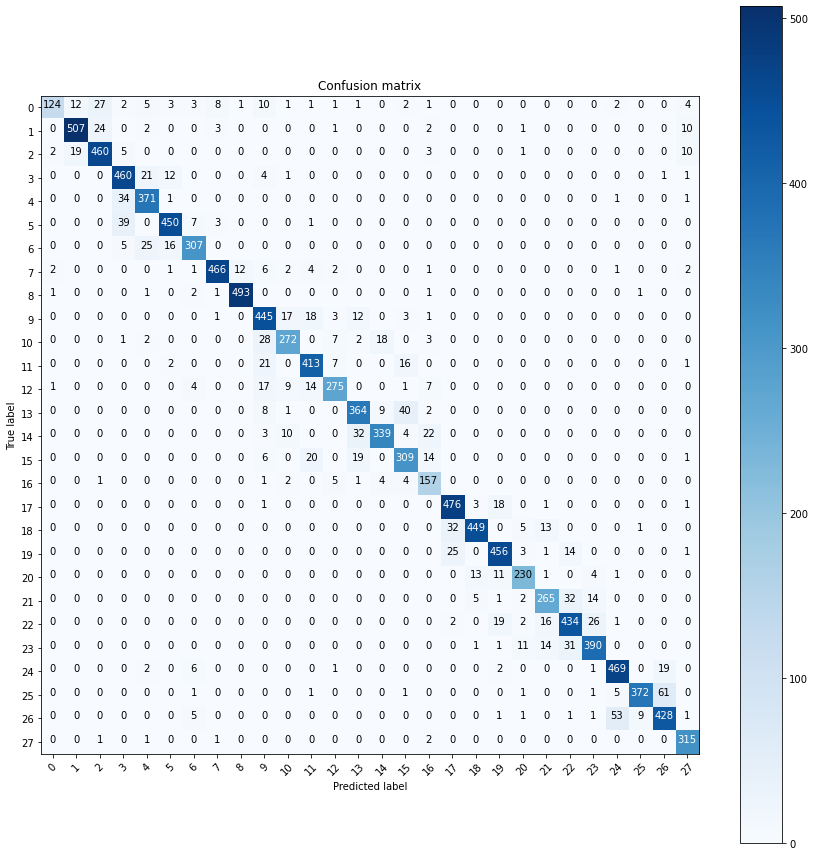

0:59.62%
1:92.18%
2:92.00%
3:92.00%
4:90.93%
5:90.00%
6:86.97%
7:93.20%
8:98.60%
9:89.00%
10:81.68%
11:89.78%
12:83.84%
13:85.85%
14:82.68%
15:83.74%
16:89.71%
17:95.20%
18:89.80%
19:91.20%
20:88.46%
21:83.07%
22:86.80%
23:87.05%
24:93.80%
25:83.97%
26:85.60%
27:98.44%
overall acc: 88.89%


In [17]:
# s_eff = predict(2, 0, r'D:\projects\Vision\TrainedModels\esophagus_28_EfficientNet-B4_20220606_380-0.902.hdf5')
# s_eff = predict(2, 0, r'D:\projects\Vision\ckpts\esophagus_28_EfficientNet-B4_20220616_01-0.902.hdf5')
s_eff = predict(2, 0, r'D:\projects\Vision\ckpts\esophagus_28_EfficientNet-B4_20220616_01-0.901.hdf5')
plot_confusion_matrix(s_eff, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27"], False, 'Confusion matrix')
calc_acc_from_matrix(s_eff)

## VGG16

Found 11820 images belonging to 28 classes.
Test data loaded: total: 11820, batch size: 32, num classes: 28

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step
27 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_08_12_21_8392-贲门_0_active_standard_c99.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_08_12_41_3892-贲门_0_active_standard_c57.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_09_09_33_5312-贲门_0_active_standard_c77.jpg
7 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_09_10_14_3402-贲门_0_active_standard_c68.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_09_11_03_0682-贲门_0_c99.jpg
1 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_09_11_20_8632-贲门_0_active_standard_c71.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_10_12_47_0974-胃窦#后壁_0_active_standard_c87.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_11_10_56_1272-贲门_0_active_standard_c67.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_06_12_09_49_8922-贲门_0_active_stand

27 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_07_03_11_45_2082-贲门_0_c99.jpg
4 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_07_06_01_18_3604-胃窦#后壁_0_active_standard_c97.jpg
27 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_07_06_02_06_7522-贲门_0_active_standard_c99.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_07_06_08_35_9307-十二指肠球部_0_active_standard_c99.jpg
1 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_07_06_09_17_1001-食管_0_active_standard_c82.jpg
2 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_07_06_09_17_1002-贲门_0_active_not_standard_c53.jpg
27 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_07_06_11_17_1232-贲门_0_active_not_standard_c50.jpg
5 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_07_07_09_42_2805-胃窦#前壁_0_active_not_standard_c55.jpg
27 0 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\00\001_0_01_2020_07_08_09_21_6527-十二指肠球部_0_active_standard_c99.jpg
2 0 \\192.168.

3 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\010001_0_005_2020_06_22_09_05_0094-胃窦#后壁_0_active_standard_c96-1.jpg
3 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\010001_0_005_2020_06_22_09_05_0094-胃窦#后壁_0_active_standard_c96-2.jpg
1 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c90&包头附二院_2021_04_29_04_01_279.jpg
1 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c95&温州中心_2021_09_15_10_31_027.jpg
1 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c96&天津中医药2021_08_24_08_18_334.jpg
27 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c96&温州中心_2021_09_17_04_09_772.jpg
1 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c98&温州中心_2021_09_07_12_00_460.jpg
1 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c98&温州中心_2021_09_22_10_21_645.jpg
27 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c99&北京朝阳_2021_08_11_09_57_872.jpg
27 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2-贲门_0_c99&北京朝阳_2021_08_17_10_40_355.jpg
27 2 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\02\2

3 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\4-胃窦#后壁_0_c98&温州中心_2021_09_13_11_14_000.jpg
3 4 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\04\4-胃窦#后壁_0_c99&温州中心_2021_09_10_10_56_893.jpg
6 5 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\05\001_0_01_2020_06_08_09_18_4646-胃窦#小弯_0_active_standard_c94.jpg
3 5 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\05\001_0_01_2020_06_08_09_45_4253-胃窦#大弯_0_active_standard_c69.jpg
3 5 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\05\001_0_01_2020_06_08_09_45_4255-胃窦#前壁_0_active_standard_c88.jpg
3 5 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\05\001_0_01_2020_06_08_12_21_8393-胃窦#大弯_0_active_standard_c84.jpg
3 5 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\05\001_0_01_2020_06_09_10_33_3415-胃窦#前壁_0_active_standard_c68.jpg
3 5 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\05\001_0_01_2020_06_11_10_05_8783-胃窦#大弯_0_active_standard_c98.jpg
7 5 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\05\001_0_01_2020_06_15_08_26_4397-十二指肠球部_0_active_standard_c92.jpg
3 5 \\192.168.0.154\数据\口咽部\大部位27分类\res

5 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_005_2020_06_18_08_14_7306-胃窦#小弯_0_active_standard_c89.jpg
4 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_005_2020_06_18_11_12_8034-胃窦#后壁_0_active_standard_c87.jpg
3 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_005_2020_06_18_11_33_0156-胃窦#小弯_0_active_standard_c55.jpg
4 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_005_2020_06_18_11_58_7066-胃窦#小弯_0_active_standard_c52.jpg
3 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\010001_0_005_2020_06_24_09_27_3856-胃窦#小弯_0_active_standard_c52.jpg
4 6 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\06\6-胃窦#小弯_0_c93&包头附二院_2021_04_21_11_10_379.jpg
0 7 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\07\001_0_01_2020_06_08_11_59_0466-胃窦#小弯_0_active_not_standard_c41.jpg
9 7 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\07\001_0_01_2020_06_09_11_43_44511-正镜胃体下部#前壁_0_active_not_standard_c68.jpg
27 7 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\07\001_0_01_2020_06_11_09_50_7427-十二指肠球部_0_active_s

11 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\001_0_01_2020_07_08_08_23_6359-正镜胃体下部#大弯_0_active_standard_c75.jpg
11 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\010001_0_001_2020_07_06_11_14_85211-正镜胃体下部#前壁_0_active_standard_c93.jpg
12 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\010001_0_005_2020_06_19_07_55_4519-正镜胃体下部#大弯_0_active_standard_c76.jpg
11 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\9-正镜胃体下部#大弯_0_c95&温州中心_2021_09_09_04_34_605.jpg
15 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\9-正镜胃体下部#大弯_0_c95&温州中心_2021_09_17_09_30_456.jpg
15 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_09_07_51_391.jpg
11 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_11_11_12_130.jpg
11 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_18_02_07_561.jpg
15 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\9-正镜胃体下部#大弯_0_c98&北京朝阳_2021_08_23_11_20_767.jpg
10 9 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\09\9-正镜胃体下部#大弯_

12 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\10-正镜胃体下部#后壁_0_c99&温州中心_2021_09_13_03_49_160.jpg
14 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\10-正镜胃体下部#后壁_0_c99&温州中心_2021_09_17_03_35_303.jpg
14 10 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\10\10-正镜胃体下部#后壁_0_c99&温州中心_2021_09_24_11_28_677.jpg
9 11 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\11\001_0_01_2020_06_08_01_17_60611-正镜胃体下部#前壁_0_active_standard_c56.jpg
9 11 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\11\001_0_01_2020_06_17_01_23_78010-正镜胃体下部#后壁_0_active_not_standard_c50.jpg
9 11 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\11\001_0_01_2020_06_17_11_24_90218-倒镜胃底#后壁_0_active_not_standard_c36.jpg
9 11 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\11\001_0_01_2020_06_30_11_07_72311-正镜胃体下部#前壁_0_active_standard_c81.jpg
9 11 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\11\001_0_01_2020_07_03_11_16_61711-正镜胃体下部#前壁_0_active_standard_c89.jpg
9 11 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\11\001_0_01_2020_07_09_08_28_21411-正镜胃体下部#前壁_0_active_standard_c52

15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\010001_0_001_2020_07_07_02_17_29013-正镜胃体中上部#大弯_0_active_standard_c98.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\010001_0_001_2020_07_09_12_27_74314-正镜胃体中上部#后壁_0_c73.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\010001_0_001_2020_07_13_12_28_25513-正镜胃体中上部#大弯_0_active_standard_c58.jpg
17 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\010001_0_001_2020_07_14_08_08_85113-正镜胃体中上部#大弯_0_active_not_standard_c45.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\010001_0_001_2020_07_20_01_19_69213-正镜胃体中上部#大弯_0_c98.jpg
9 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\010001_0_001_2020_07_21_01_13_48513-正镜胃体中上部#大弯_0_c99.jpg
9 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\010001_0_001_2020_07_21_12_57_86013-正镜胃体中上部#大弯_0_active_standard_c90.jpg
9 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\010001_0_001_2020_07_21_12_57_86013-正镜胃体中上部#大弯_0_c99.jpg
14 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\010001_0_001_2020_07_21_12_57

15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c99&温州中心_2021_09_16_09_05_575.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c99&温州中心_2021_09_17_02_40_593.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c99&温州中心_2021_09_17_03_52_189.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c99&温州中心_2021_09_17_04_09_772.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c99&温州中心_2021_09_17_08_25_091.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c99&温州中心_2021_09_17_08_56_786.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c99&温州中心_2021_09_20_09_24_020.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c99&温州中心_2021_09_20_11_34_198.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c99&温州中心_2021_09_22_02_19_943.jpg
15 13 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\13\13-正镜胃体中上部#大弯_0_c99&温州中心_2021_09_22_03_09_459.jpg


11 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c91&温州中心_2021_09_06_11_06_694.jpg
10 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c91&温州中心_2021_09_09_03_27_193.jpg
15 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c92&天津中医药2021_09_18_10_12_893.jpg
13 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c95&温州中心_2021_09_13_02_11_836.jpg
16 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c96&包头附二院_2021_04_27_04_18_714.jpg
16 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c96&天津中医药2021_08_25_10_34_880.jpg
13 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c96&温州中心_2021_09_03_12_19_030.jpg
15 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c96&温州中心_2021_09_22_02_02_106.jpg
16 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c98&包头附二院_2021_04_20_09_12_628.jpg
15 14 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\14\14-正镜胃体中上部#后壁_0_c98&北京朝阳_2021_08_10_10_56_826.jp

13 15 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\15\15-正镜胃体中上部#前壁_0_c95&天津中医药2021_09_06_10_39_339.jpg
11 15 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\15\15-正镜胃体中上部#前壁_0_c96&温州中心_2021_09_10_02_27_088.jpg
11 15 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\15\15-正镜胃体中上部#前壁_0_c97&北京朝阳_2021_08_02_09_10_762.jpg
11 15 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\15\15-正镜胃体中上部#前壁_0_c97&温州中心_2021_09_07_10_13_891.jpg
11 15 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\15\15-正镜胃体中上部#前壁_0_c97&温州中心_2021_09_17_03_52_189.jpg
11 15 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\15\15-正镜胃体中上部#前壁_0_c97&温州中心_2021_09_20_10_21_013.jpg
11 15 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\15\15-正镜胃体中上部#前壁_0_c97&温州中心_2021_09_23_03_34_354.jpg
11 15 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\15\15-正镜胃体中上部#前壁_0_c98&包头附二院_2021_04_19_09_48_112.jpg
11 15 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\15\15-正镜胃体中上部#前壁_0_c98&温州中心_2021_09_15_09_30_451.jpg
11 15 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\15\15-正镜胃体中上部#前壁_0_c99&北京朝阳_2021_08_20_08_39_044.jpg

18 17 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\17\17-倒镜胃底#大弯_0_c70&温州中心_2021_09_15_02_08_626.jpg
18 17 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\17\17-倒镜胃底#大弯_0_c74&包头附二院_2021_04_08_09_56_919.jpg
18 17 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\17\17-倒镜胃底#大弯_0_c99&天津中医药2021_08_26_09_09_380.jpg
18 17 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\17\17-倒镜胃底#大弯_0_c99&温州中心_2021_09_01_09_47_409.jpg
18 17 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\17\17-倒镜胃底#大弯_0_c99&温州中心_2021_09_17_02_03_709.jpg
19 17 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\17\17-倒镜胃底#大弯_0_c99&温州中心_2021_09_20_08_05_171.jpg
19 17 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\17\17-倒镜胃底#大弯_0_c99&温州中心_2021_09_20_10_21_013.jpg
18 17 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\17\17-倒镜胃底#大弯_0_c99&温州中心_2021_09_22_02_02_106.jpg
21 18 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\18\001_0_01_2020_06_08_09_45_42522-倒镜胃体中上部#前壁_0_active_not_standard_c50.jpg
17 18 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\18\001_0_01_2020_06_15_09_23_52317-倒镜胃底#大弯_0_active_s

19 20 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\20\001_0_01_2020_06_17_01_00_62818-倒镜胃底#后壁_0_active_not_standard_c50.jpg
19 20 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\20\001_0_01_2020_06_17_01_00_62819-倒镜胃底#前壁_0_active_standard_c81.jpg
18 20 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\20\001_0_01_2020_06_17_08_02_46718-倒镜胃底#后壁_0_active_standard_c97.jpg
18 20 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\20\001_0_01_2020_06_17_08_02_46720-倒镜胃底#小弯_0_active_standard_c73.jpg
19 20 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\20\001_0_01_2020_06_17_12_07_61120-倒镜胃底#小弯_0_active_standard_c65.jpg
18 20 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\20\001_0_01_2020_06_19_09_40_33415-正镜胃体中上部#前壁_0_c87.jpg
21 20 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\20\001_0_01_2020_06_19_11_53_97421-倒镜胃体中上部#后壁_0_active_not_standard_c69.jpg
19 20 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\20\001_0_01_2020_06_22_08_58_37120-倒镜胃底#小弯_0_active_standard_c50.jpg
19 20 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\20\001_0_01_2020_06_30_10_2

22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\010001_0_001_2020_07_27_08_53_78721-倒镜胃体中上部#后壁_0_active_not_standard_c50.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\010001_0_001_2020_07_27_08_53_78721-倒镜胃体中上部#后壁_0_c95.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\010001_0_001_2020_07_27_09_52_97521-倒镜胃体中上部#后壁_0_c88.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\010001_0_001_2020_07_27_11_12_71721-倒镜胃体中上部#后壁_0_active_standard_c76.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\010001_0_001_2020_07_29_02_05_10221-倒镜胃体中上部#后壁_0_c94.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\010001_0_001_2020_07_29_09_11_80321-倒镜胃体中上部#后壁_0_c57.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\010001_0_001_2020_07_29_10_56_95421-倒镜胃体中上部#后壁_0_active_standard_c70.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\010001_0_001_2020_07_29_10_56_95421-倒镜胃体中上部#后壁_0_c91.jpg
22 21 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\21\010001_0_001_2020_07_30_08_46_98721-倒镜胃体中上

23 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\22-倒镜胃体中上部#前壁_0_c98&温州中心_2021_09_01_02_38_941.jpg
21 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\22-倒镜胃体中上部#前壁_0_c98&温州中心_2021_09_15_02_08_626.jpg
21 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\22-倒镜胃体中上部#前壁_0_c98&温州中心_2021_09_16_03_42_765.jpg
23 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\22-倒镜胃体中上部#前壁_0_c99&北京朝阳_2021_08_03_08_28_136.jpg
19 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\22-倒镜胃体中上部#前壁_0_c99&北京朝阳_2021_09_06_01_22_236.jpg
19 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\22-倒镜胃体中上部#前壁_0_c99&天津中医药2021_09_15_08_42_898.jpg
23 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\22-倒镜胃体中上部#前壁_0_c99&温州中心_2021_09_09_03_58_162.jpg
19 22 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\22\22-倒镜胃体中上部#前壁_0_c99&温州中心_2021_09_23_09_41_662.jpg
22 23 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\23\001_0_005_2020_06_12_12_07_91023-倒镜胃体中上部#小弯_0_active_standard_c98.jpg
22 23 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\23\001_0_01_2020_06_09_09_33_5312

26 24 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\24\010001_0_001_2020_07_07_10_03_67124-倒镜胃角#后壁_0_active_standard_c71.jpg
26 24 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\24\010001_0_001_2020_07_10_08_56_30224-倒镜胃角#后壁_0_active_standard_c79.jpg
26 24 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\24\010001_0_001_2020_07_16_10_50_67724-倒镜胃角#后壁_0_active_standard_c52.jpg
26 24 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\24\010001_0_001_2020_07_27_08_45_78224-倒镜胃角#后壁_0_active_standard_c49.jpg
21 24 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\24\010001_0_001_2020_07_27_10_17_69021-倒镜胃体中上部#后壁_0_active_standard_c45.jpg
21 24 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\24\010001_0_001_2020_07_30_08_59_66521-倒镜胃体中上部#后壁_0_c57.jpg
26 24 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\24\010001_0_001_2020_07_30_08_59_66524-倒镜胃角#后壁_0_active_standard_c62.jpg
26 24 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\24\010001_0_005_2020_06_17_12_36_24324-倒镜胃角#后壁_0_active_standard_c61.jpg
26 24 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\24\

26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\25-倒镜胃角#前壁_0_c97&北京朝阳_2021_08_11_09_30_568.jpg
5 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\25-倒镜胃角#前壁_0_c98&温州中心_2021_09_15_10_14_705.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\25-倒镜胃角#前壁_0_c99&天津中医药2021_08_25_08_46_602.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\25-倒镜胃角#前壁_0_c99&天津中医药2021_09_01_08_57_019.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\25-倒镜胃角#前壁_0_c99&天津中医药2021_09_03_09_20_700.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\25-倒镜胃角#前壁_0_c99&天津中医药2021_09_06_09_34_683.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\25-倒镜胃角#前壁_0_c99&天津中医药2021_09_07_08_34_655.jpg
6 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\25-倒镜胃角#前壁_0_c99&天津中医药2021_09_15_09_53_872.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\25-倒镜胃角#前壁_0_c99&温州中心_2021_09_01_12_01_581.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\25\25-倒镜胃角#前壁_0_c99&温州中心_2021_09_04_10_08_938.jpg
26 25 \\192.168.0.154\数据\口咽部\大部位

2 27 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\27\001_0_01_2020_06_19_11_42_4581-食管_0_active_standard_c68.jpg
1 27 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\27\001_0_01_2020_06_29_11_51_7372-贲门_0_c99.jpg
7 27 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\27\001_0_01_2020_07_01_12_01_1597-十二指肠球部_0_c99.jpg
2 27 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\27\001_0_01_2020_07_02_08_58_8082-贲门_0_active_standard_c99.jpg
2 27 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\27\01.0000000202872.0156.1628041703.jpg
7 27 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\27\20180711_10_14_02_000000196150.jpg
19 27 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\27\20180714_10_40_31_000000224402.jpg
12 27 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\27\20180718_11_37_44_000000756976.jpg
0 27 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\27\20181204_12_20_32_000000198674.jpg
2 27 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\27\202110250864#20211027095553768.jpg
2 27 \\192.168.0.154\数据\口咽部\大部位27分类\res_test2\27\f1158_99_class4.jpg
2 27 \\192.168.

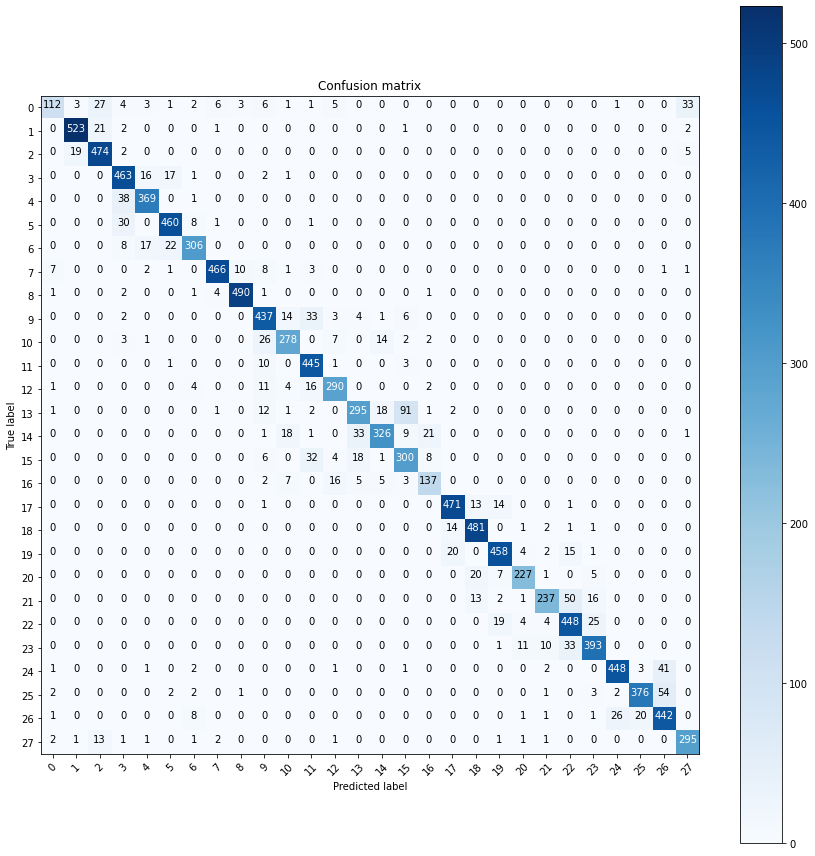

0:53.85%
1:95.09%
2:94.80%
3:92.60%
4:90.44%
5:92.00%
6:86.69%
7:93.20%
8:98.00%
9:87.40%
10:83.48%
11:96.74%
12:88.41%
13:69.58%
14:79.51%
15:81.30%
16:78.29%
17:94.20%
18:96.20%
19:91.60%
20:87.31%
21:74.29%
22:89.60%
23:87.72%
24:89.60%
25:84.88%
26:88.40%
27:92.19%
overall acc: 88.47%


In [16]:
s_eff_vgg16 = predict(0, 0, r'D:\projects\Vision\TrainedModels\esophagus_28_VGG16_20220602_04-0.902.hdf5')
plot_confusion_matrix(s_eff_vgg16, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27"], False, 'Confusion matrix')
calc_acc_from_matrix(s_eff_vgg16)

## ResNet50

In [17]:
s_eff_res50 = predict(1, 0, r'D:\projects\Vision\TrainedModels\esophagus_28_ResNet50_20220602_01-0.864.hdf5')
plot_confusion_matrix(s_eff_res50, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27"], False, 'Confusion matrix')
calc_acc_from_matrix(s_eff_res50)

Found 11550 images belonging to 28 classes.
Test data loaded: total: 11550, batch size: 32, num classes: 28

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step
